# 1. Dataset Loading

## Loading Trimesh Data as Torch_Geometric `Data` object
Using the built in function in `PyTorch-Geometric`(PyG) that allows the conversion of trimesh (.stl) to the [PyG Data object](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data)

also, from pytorch_geometric [documentation](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html), we should be able to use our own dataset by creating a python list holding the `torch_geometric.data.Data` object (defined above) ---- there may be no need of defining a custom `dataloader` object

In [2]:
import argparse
import os
import os.path as osp
import time

import trimesh

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.utils import from_trimesh, to_trimesh#, to_edge_index

from torch.utils.tensorboard import SummaryWriter

# from models import FeaStNet
# import FeaStNet
# from utils import run

In [3]:
os.chdir("C:\\Users\jsl3a\Desktop\MSc Project Dataset\\nnUNet_raw\\Dataset001_amosCT")

## 1.1 `trimesh2datalist` function
the function that reads in the trimesh as `stl` Object, then uses the `from_trimesh` method from `torch_geometric.utils.` to convert it to a `torch_geometric.data.Data` object

In [4]:
def trimesh2datalist(input_path):
    """read all trimesh from input_path, append to a list and return the list

    Args:
        input_path: The path to the trimesh files.

    Returns:
        a list with all the trimesh object in the path
    """
    #get item list to call functions on
    item_list = os.listdir(input_path)
    
    list = []

    #for all the item in input folder:
    for i in range(len(item_list)):
        in_path = input_path+"\\"+item_list[i]#set input path, start from folder
        mesh = trimesh.load(in_path)
        item = from_trimesh(mesh)
        list.append(item)
    
    return list

In [5]:
start_time = time.time()

#load training and validation data into lists
tr_data = trimesh2datalist("version1/gb_stl_tr")
va_data = trimesh2datalist("version1/gb_stl_va")
   
elapsed_time_min = (time.time() - start_time)/60
print(f"Elapsed time: {elapsed_time_min:.2f} minutes")

Elapsed time: 0.04 minutes


In [6]:
tr_data[0:5]

[Data(pos=[2930, 3], face=[3, 5835]),
 Data(pos=[8395, 3], face=[3, 16794]),
 Data(pos=[8939, 3], face=[3, 17868]),
 Data(pos=[4750, 3], face=[3, 9493]),
 Data(pos=[5110, 3], face=[3, 10207])]

In [7]:
#checking the length of both data lists
print(len(tr_data))
print(len(va_data))

163
66


In [8]:
#to validate dataset, not sure what this really means tho...
tr_data[0].validate(raise_on_error=True)

True

In [9]:
#to validate dataset, not sure what this really means tho...
va_data[0].validate(raise_on_error=True)

True

## 1.2 Data conversion - creating `x` and `edge_index` attributes 
the `forward` function for the VGAE we will define later requires the `Data` object to have:
1. an `x` attributes that represents the ***node features*** of the graph (in this case mesh) object, 
2. as well as an `edge_index` that captures the ***two nodes for each edge*** in the graph.

Since the mesh data has component of `pos` and `face` instead of the regular `x` and `edge_index` found in graph, we need to **process the data** and create the equivalent of `x` and `edge_index` before proceeding to building the **VGAE**. 

To perform the conversion we need to understand what the different attribute represents and what are the differeces:

#### `trimesh` Data object - *intended input*
Each of the **trimesh** converted Data object has `pos` and `face` attributes:
* The `pos` attribute has the shape of `(num_nodes, 3)` and represents the **3D coordinates of each node** in the mesh.
* The `face` attribute has a shape of `(3, num_face)` and represents the indices of the **three nodes** that make up ***each face*** (a.k.a triangle)

#### `graph` Data object - *template input*
The ***graph*** input found in other GCN tutorial that I can find has `x` and `edge_index` attributes each:
* The `x` attribute has a shape of `(num_nodes, num_features)`, storing the **features of each node** in the graph.
* The `edge_index` attribute has a shape of `(2, num_edges)` that stores the indices of the **two nodes** that are connected by ***each edge*** in the graph

lets use one example below to understand the data

In [10]:
data = tr_data[0]
print(data)
print(data.pos.shape)
print(data.pos)

Data(pos=[2930, 3], face=[3, 5835])
torch.Size([2930, 3])
tensor([[154.8360, 203.3200,   0.0000],
        [154.9914, 204.5052,   3.1762],
        [154.4188, 204.3561,   2.0292],
        ...,
        [127.7109, 232.4861,  39.9883],
        [128.1264, 232.7777,  39.9796],
        [128.4115, 232.8129,  39.9462]])


In [11]:
print(data.face.shape)
data.face

torch.Size([3, 5835])


tensor([[   0,    3,    4,  ..., 2803, 2843, 2816],
        [   1,    0,    5,  ..., 2840, 2820, 2840],
        [   2,    2,    0,  ..., 2816, 2840, 2820]])

## 1.3 Conversion of `pos` to `x`
The `pos` attribute can be understood as the `x` node feature, with 3 features for each node that represents its location in space. Therefore,

**we keep `pos` as node feature `x` and keep its shape of `(num_nodes, 3)`**

In [12]:
data.pos

tensor([[154.8360, 203.3200,   0.0000],
        [154.9914, 204.5052,   3.1762],
        [154.4188, 204.3561,   2.0292],
        ...,
        [127.7109, 232.4861,  39.9883],
        [128.1264, 232.7777,  39.9796],
        [128.4115, 232.8129,  39.9462]])

## 1.4 Conversion of `faces` to `edge_index`
As for `edge_index`, we can try to extract that from `faces`. We do that by extracting 3 edges (pairs of nodes) from each face from `faces`.

so for *each row in `pos`*, where the tensor have 3 nodes `[a, b, c]` that makes up a face/ triangle, we extract 3 edges `[a, b]`, `[b, c]`, `[a, c]`.

#### function for the conversion:

In [13]:
def get_edgeindex(data):
    # Step 1: Create the node features (x) using the positions (pos)
    x = data.pos
    face = data.face

    # Step 2: Create the adjacency matrix (edge_index) from the faces
    edge_index_list = []
    for faces in data.face.t():
        # Create three edges for each face (triangle)
        edge1 = torch.tensor([faces[0], faces[1]])
        edge2 = torch.tensor([faces[1], faces[2]])
        edge3 = torch.tensor([faces[2], faces[0]])
        # Append the edges to the edge_index_list
        edge_index_list.extend([edge1, edge2, edge3])

    # Concatenate all edges into a single tensor
    edge_index = torch.stack(edge_index_list, dim=0).t().contiguous()

    # Create the PyTorch Geometric Data object
    new_data = Data(x=x, edge_index=edge_index, pos=data.pos, face=face)

    return(new_data)

new = get_edgeindex(data)
new

Data(x=[2930, 3], edge_index=[2, 17505], pos=[2930, 3], face=[3, 5835])

In [14]:
data

Data(pos=[2930, 3], face=[3, 5835])

To make this a one time process, we will perform this operation on all the data in **training list** and **validation list** before loading them into the `Dataloader` & put to use in the model later:

In [15]:
start_time = time.time()

tr_data_processed = []
for data in tr_data:
    data = get_edgeindex(data)
    tr_data_processed.append(data)
    
elapsed_time_min = (time.time() - start_time)/60
print(f"Elapsed time: {elapsed_time_min:.2f} minutes")

Elapsed time: 0.81 minutes


In [16]:
tr_data_processed

[Data(x=[2930, 3], edge_index=[2, 17505], pos=[2930, 3], face=[3, 5835]),
 Data(x=[8395, 3], edge_index=[2, 50382], pos=[8395, 3], face=[3, 16794]),
 Data(x=[8939, 3], edge_index=[2, 53604], pos=[8939, 3], face=[3, 17868]),
 Data(x=[4750, 3], edge_index=[2, 28479], pos=[4750, 3], face=[3, 9493]),
 Data(x=[5110, 3], edge_index=[2, 30621], pos=[5110, 3], face=[3, 10207]),
 Data(x=[9572, 3], edge_index=[2, 57369], pos=[9572, 3], face=[3, 19123]),
 Data(x=[3824, 3], edge_index=[2, 22887], pos=[3824, 3], face=[3, 7629]),
 Data(x=[3657, 3], edge_index=[2, 21900], pos=[3657, 3], face=[3, 7300]),
 Data(x=[6024, 3], edge_index=[2, 36114], pos=[6024, 3], face=[3, 12038]),
 Data(x=[5804, 3], edge_index=[2, 34812], pos=[5804, 3], face=[3, 11604]),
 Data(x=[5802, 3], edge_index=[2, 34800], pos=[5802, 3], face=[3, 11600]),
 Data(x=[3905, 3], edge_index=[2, 23388], pos=[3905, 3], face=[3, 7796]),
 Data(x=[3308, 3], edge_index=[2, 19797], pos=[3308, 3], face=[3, 6599]),
 Data(x=[2624, 3], edge_index=[

In [16]:
start_time = time.time()

va_data_processed = []
for data in va_data:
    data = get_edgeindex(data)
    va_data_processed.append(data)
    
elapsed_time_min = (time.time() - start_time)/60
print(f"Elapsed time: {elapsed_time_min:.2f} minutes")

Elapsed time: 0.33 minutes


In [17]:
va_data_processed

[Data(x=[3736, 3], edge_index=[2, 22395], pos=[3736, 3], face=[3, 7465]),
 Data(x=[5456, 3], edge_index=[2, 32715], pos=[5456, 3], face=[3, 10905]),
 Data(x=[2336, 3], edge_index=[2, 14004], pos=[2336, 3], face=[3, 4668]),
 Data(x=[3713, 3], edge_index=[2, 22257], pos=[3713, 3], face=[3, 7419]),
 Data(x=[4640, 3], edge_index=[2, 27792], pos=[4640, 3], face=[3, 9264]),
 Data(x=[4469, 3], edge_index=[2, 26802], pos=[4469, 3], face=[3, 8934]),
 Data(x=[4187, 3], edge_index=[2, 25083], pos=[4187, 3], face=[3, 8361]),
 Data(x=[3661, 3], edge_index=[2, 21840], pos=[3661, 3], face=[3, 7280]),
 Data(x=[3043, 3], edge_index=[2, 18246], pos=[3043, 3], face=[3, 6082]),
 Data(x=[3130, 3], edge_index=[2, 18771], pos=[3130, 3], face=[3, 6257]),
 Data(x=[3916, 3], edge_index=[2, 23469], pos=[3916, 3], face=[3, 7823]),
 Data(x=[3884, 3], edge_index=[2, 23253], pos=[3884, 3], face=[3, 7751]),
 Data(x=[6817, 3], edge_index=[2, 40893], pos=[6817, 3], face=[3, 13631]),
 Data(x=[4271, 3], edge_index=[2, 25

## 1.5 Load the lists into `Dataloader`:

We have to turn off `shuffle` for training `dataloader` here as we need to find the **corresponding data attributes** to perform calculation in sections later (2 & 3).

In [18]:
tr_loader = DataLoader(tr_data_processed, batch_size = 1) #, shuffle=True)
# va_loader = DataLoader(va_data_processed, batch_size = 1) 

In [19]:
for i, data in enumerate(tr_loader, 0):
    print(i, data)

0 DataBatch(x=[2930, 3], edge_index=[2, 17505], pos=[2930, 3], face=[3, 5835], batch=[2930], ptr=[2])
1 DataBatch(x=[8395, 3], edge_index=[2, 50382], pos=[8395, 3], face=[3, 16794], batch=[8395], ptr=[2])
2 DataBatch(x=[8939, 3], edge_index=[2, 53604], pos=[8939, 3], face=[3, 17868], batch=[8939], ptr=[2])
3 DataBatch(x=[4750, 3], edge_index=[2, 28479], pos=[4750, 3], face=[3, 9493], batch=[4750], ptr=[2])
4 DataBatch(x=[5110, 3], edge_index=[2, 30621], pos=[5110, 3], face=[3, 10207], batch=[5110], ptr=[2])
5 DataBatch(x=[9572, 3], edge_index=[2, 57369], pos=[9572, 3], face=[3, 19123], batch=[9572], ptr=[2])
6 DataBatch(x=[3824, 3], edge_index=[2, 22887], pos=[3824, 3], face=[3, 7629], batch=[3824], ptr=[2])
7 DataBatch(x=[3657, 3], edge_index=[2, 21900], pos=[3657, 3], face=[3, 7300], batch=[3657], ptr=[2])
8 DataBatch(x=[6024, 3], edge_index=[2, 36114], pos=[6024, 3], face=[3, 12038], batch=[6024], ptr=[2])
9 DataBatch(x=[5804, 3], edge_index=[2, 34812], pos=[5804, 3], face=[3, 11604

In [20]:
# for i, data in enumerate(va_loader, 0):
#     print(i, data)

# 2. Variational Graph Autoencoder (VGAE)

We essentially define a variational graph encoder with `FeaStConv` layers. With the `decoder` being the mirrored version of the `encoder`.

Refering to Soodeh's paper for the model built:

The paper mentioned the a combination of spatial-based GCN layers (`FeaStConv`) and BatchNorm layers. The GCN layers have dimensions of `(64, 64, 128, 128)` for the hidden layers. Also, the conv filter weight matrices has a size of 8.

## 2.1 Defining the VGAE
with `x` and `edge_index` ready, we can define the encoder and its `forward` function. Before that, we need to define and override some of `VGAE` class functions.

some of the code refers to the [pytorch-geometric source code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/autoencoder.html)

In [17]:
from torch_geometric.nn import norm, GAE
from torch_geometric.nn.conv import FeaStConv 
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10

class VGAE(GAE):
    def __init__(self, encoder, decoder = None):
        super().__init__(encoder, decoder)

    def encode(self, x, edge_index):
        return self.encoder(x, edge_index)
    
    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    #source code
    def reparameterize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu

    #modified for usecase
    def forward(self, x, edge_index):
        z_mean, z_logstd = self.encode(x, edge_index)
        z = self.reparameterize(z_mean, z_logstd)
        recon_x = self.decoder(z, edge_index)
        return recon_x, z
    
    
    #from source code 
    def kl_loss(self, mu = None, logstd = None):
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))
    
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self):#, latent_dim):
        super(VariationalGCNEncoder, self).__init__()

        self.conv_layers = nn.Sequential(
            FeaStConv(3, 64),
            norm.BatchNorm(64), 
            FeaStConv(64, 64),
            norm.BatchNorm(64), 
            FeaStConv(64, 128),
            norm.BatchNorm(128),
        )
        
        self.conv_mu = FeaStConv(128, 128)
        self.conv_logstd = FeaStConv(128, 128)

    def forward(self, x, edge_index): 
        for conv in self.conv_layers:
            if isinstance(conv, FeaStConv):
                x = conv(x, edge_index)
            else:
                x = conv(x)
        
        z_mean = self.conv_mu(x, edge_index)
        z_logstd = self.conv_logstd(x, edge_index)
        
        return z_mean, z_logstd
    
#from source code
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.conv_layers = nn.Sequential(
            FeaStConv(128, 128),
            norm.BatchNorm(128), 
            FeaStConv(128, 64),
            norm.BatchNorm(64), 
            FeaStConv(64, 64),
            norm.BatchNorm(64),
            FeaStConv(64, 3),
        )
        
    
    def forward(self, z, edge_index, sigmoid = True):
        for conv in self.conv_layers:
            if isinstance(conv, FeaStConv):
                z = conv(z, edge_index)
            else:
                z = conv(z)
        
        x_prime = z
        
#         return torch.sigmoid(x_prime) if sigmoid else x_prime
        return x_prime


As there is no source code to refer to, the model may be a little different from soodeh's documentation (Table S1). There is **no** real mention of **activation functions** being deployed in this VGAE model, and from my trail and error, any amount of activation functions (I tried `LeakyReLU`) added will lead to the model no being able to reproduce a 3D mesh (they will look flat in Paraview 5.11.1)

In [22]:
#defines the AE using the encoder layer we defined
model = VGAE(VariationalGCNEncoder(), Decoder())
model

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv_layers): Sequential(
      (0): FeaStConv(3, 64, heads=1)
      (1): BatchNorm(64)
      (2): FeaStConv(64, 64, heads=1)
      (3): BatchNorm(64)
      (4): FeaStConv(64, 128, heads=1)
      (5): BatchNorm(128)
    )
    (conv_mu): FeaStConv(128, 128, heads=1)
    (conv_logstd): FeaStConv(128, 128, heads=1)
  )
  (decoder): Decoder(
    (conv_layers): Sequential(
      (0): FeaStConv(128, 128, heads=1)
      (1): BatchNorm(128)
      (2): FeaStConv(128, 64, heads=1)
      (3): BatchNorm(64)
      (4): FeaStConv(64, 64, heads=1)
      (5): BatchNorm(64)
      (6): FeaStConv(64, 3, heads=1)
    )
  )
)

## 2.2 Training VGAE
the `train` function will be called for each epoch. Each epoch will loop through the `tr_loader`, and loss will be calculated as the combination of reconstruction loss (MSELoss) and KL Divergence. The loss is then backproped through the model, with `optimizer` performing the step.

In [23]:
#new train() for testing
w_kl = 1e-3 #referring to soodeh's paper

def train(model, loss_func):
    running_loss = 0  
    model.train()
    for i, data in enumerate(tr_loader, 0):
        optimizer.zero_grad()
        data = data.to(device)
        z_mean, z_logstd = model.encode(data.x, data.edge_index)
        z = model.reparameterize(z_mean, z_logstd)
        recon_x = model.decoder(z, data.edge_index)
        rec_loss = loss_func(recon_x, data.x)
        loss = rec_loss + w_kl*model.kl_loss(z_mean, z_logstd)
        loss.backward()
        optimizer.step()
        running_loss += float(loss)
    return running_loss

In [24]:
#moving all the pieces onto GPU before the training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
epochs = 200

loss_func = nn.MSELoss()

#first training
# running_loss = 0

start_time = time.time() 

for epoch in range(1, epochs + 1):
    loss = train(model, loss_func)
    if ((epoch-1)%10==0):
        print('Epoch: {:03d}, loss: {:.4f}'.format(epoch, loss))  
        
end_time = time.time()
elapsed_time_min = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time_min:.2f} minutes")

Epoch: 001, loss: 3587411.1099
Epoch: 011, loss: 192489.5091
Epoch: 021, loss: 168161.4746
Epoch: 031, loss: 167513.7792
Epoch: 041, loss: 167294.1206
Epoch: 051, loss: 167254.8278
Epoch: 061, loss: 167203.8553
Epoch: 071, loss: 167176.7552
Epoch: 081, loss: 167142.2321
Epoch: 091, loss: 167139.0698
Epoch: 101, loss: 167082.5667
Epoch: 111, loss: 167112.0229
Epoch: 121, loss: 167083.9573
Epoch: 131, loss: 167074.8871
Epoch: 141, loss: 167107.2429
Epoch: 151, loss: 167069.1106
Epoch: 161, loss: 167047.4855
Epoch: 171, loss: 167004.3380
Epoch: 181, loss: 167003.4550
Epoch: 191, loss: 166984.4985
Elapsed time: 14.44 minutes


In [25]:
# file_path = "model/vgae_100.pth"
# file_path = "model/vgae_200b.pth" #with leakyrelu for dist.
file_path = "model/vgae_200_4Sep.pth" #final version.

# Save the entire model state (including model parameters and other information)

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(checkpoint, file_path)

after the training process, we will make use of only the **encoder** to get the **z** embeddings.

### 2.2.1 Loading the model for further training
*(rerun this part to continue training in fragments)*


~~at the current config. (as of 1Aug2023) each epoch is gonna run for about 6~7 minutes and we have ran it for 50 epochs. we defo wanna save the model after the training:~~

In [18]:
# os.chdir("C:\\Users\jsl3a\Desktop\MSc Project Dataset\\nnUNet_raw\\Dataset001_amosCT")

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Define the file path where you want to save the model
# # file_path = "model/vgae_100.pth"
# # file_path = "model/vgae_200b.pth"
# file_path = "model/vgae_200_4Sep.pth" #final version.

# model = VGAE(VariationalGCNEncoder(), Decoder())
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #was 0.01 for

# #loading checkpoint to resume training
# checkpoint = torch.load(file_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [27]:
# #revised training, continue to train the model from above (trained for 50 epochs)
# #train for short time (~10epochs) through different times

# start_time = time.time()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# epochs = 200

# running_loss = 0

# for epoch in range(1, epochs + 1):
#     loss = train(model)
#     if ((epoch-1)%10==0):
#         print('Epoch: {:03d}, loss: {:.4f}'.format(epoch, loss))
        
    
# end_time = time.time()
# elapsed_time_min = (end_time - start_time)/60
# print(f"Elapsed time: {elapsed_time_min:.2f} minutes")


In [28]:
# # Define the file path where you want to save the model
# # file_path = "model/model_70.pth"
# # file_path = "model/model_80.pth"
# # file_path = "model/model_90.pth"
# # file_path = "model/model_100.pth"
# # file_path = "model/model_110.pth"
# file_path = "model/VGAE_200.pth"

# # Save the entire model state (including model parameters and other information)

# checkpoint = {
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
# }

# torch.save(checkpoint, file_path)


### 2.2.2 Checking the trained VGAE:
* try to see if the output from VGAE is correct
* make it into mesh & check

In [25]:
#to generate post vgae meshes
model = model.to(device)
model.eval()

# vgae_mesh_list = []

for i in range(len(tr_data_processed)):
    curr_data = tr_data_processed[i]
    new_nodes, _ = model(curr_data.x.to(device),curr_data.edge_index.to(device))
    new_nodes = new_nodes.detach().cpu()
    
    mesh = trimesh.Trimesh(vertices=new_nodes, faces=tr_data_processed[i].face.t())
    mesh.export("version1/vgae_mesh/mesh"+str(i)+".stl")
#     vgae_mesh_list.append(mesh)

In [29]:
nodes0 = tr_data_processed[0].x.to(device)
ei0 = tr_data_processed[0].edge_index.to(device)
nodes35 = tr_data_processed[17].x.to(device)
ei35 = tr_data_processed[17].edge_index.to(device)

model = model.to(device)
model.eval()

re_n0, _ = model(nodes0, ei0)
re_n35, _ = model(nodes35, ei35)

re_n0 = re_n0.detach().cpu()
re_n35 = re_n35.detach().cpu()

mesh0 = trimesh.Trimesh(vertices=re_n0, faces=tr_data_processed[0].face.t())
mesh35 = trimesh.Trimesh(vertices=re_n35, faces=tr_data_processed[17].face.t())

mesh0.export("mesh0.stl")
mesh35.export("mesh35.stl")

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00v!\x00\x00S\xc9\x92\xbeq[K\xbf\x8e\x18\t\xbfFEAC\xe42\x9dC{1*@>\xdd@C3\xea\x9cCX\x07n@\xf6\x8e@C\xf9+\x9dCU\xb9G@\x00\x00\xd8\'[\xbe$\x8dM\xbf\xf4j\x0e\xbfFEAC\xe42\x9dC{1*@;\xfcACd,\x9dC\xb1I\x1d@\xe5tAC\xb1\xdd\x9cC\xe2\x18c@\x00\x00\x12+\x92\xbed\x7fK\xbf{\r\t\xbf>\xdd@C3\xea\x9cCX\x07n@FEAC\xe42\x9dC{1*@\xe5tAC\xb1\xdd\x9cC\xe2\x18c@\x00\x003\xcf/\xbey{K\xbfg\xfe\x14\xbf;\xfcACd,\x9dC\xb1I\x1d@\xfc\xabBC{$\x9dCM\xba\x15@\x99&BCP\xd6\x9cC6\xf1T@\x00\x00\xf6\xefz\xbe\x89\xf8I\xbf\x1b@\x10\xbf\xe5tAC\xb1\xdd\x9cC\xe2\x18c@;\xfcACd,\x9dC\xb1I\x1d@\x99&BCP\xd6\x9cC6\xf1T@\x00\x00\x89\xc9!\xbe\x03VH\xbf*)\x1a\xbf\xfc\xabBC{$\x9dCM\xba\x15@Z,CC\xe0\x19\x9dC\xed2\x14@\\\xd4

These mesh works! (VGAE output `x`=node features + original data `edge_index`)\
output (made into `mesh35`) shown below:

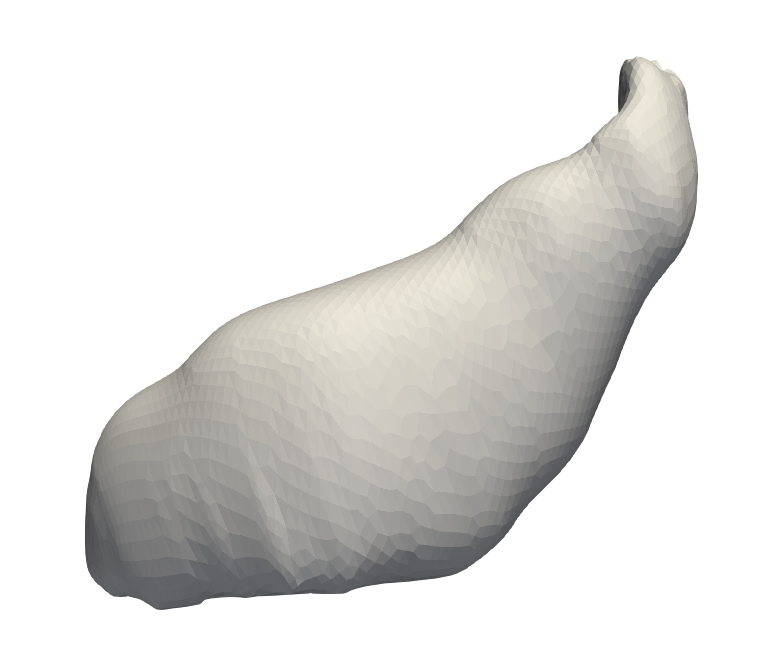

# 2. Attention Mechanism
Soodeh's documentation discuss an **Attention-based Shape Matching** that works with the **VGAE** to establish ***vertex-to-vertex correspondences*** between the shapes in the latent space. Shapes here being each the $k$-th **observed** shape/graph/mesh and the **template** shape/graph/mesh.

To achieve that we will have to 
1. hand-pick a template graph from the training set
2. retrieve all the z embeddings from VGAE encoder above
3. perform the calculations for each of observed graph $g_k$ against the template graph $g_t$

The calculation is a simple `softmax` function over a *dot product* that can be represented in formula below: 

$C_k = Softmax(\lambda Z_t Z_k^T)$

where the $Z_t$ and $Z_k$ represents the **nodal embedding vectors** of the **template graph** and $k$-th **observed graph** respectively *(is transposed, thus the $T$)*.

The output will be a **soft correspondence** (i.e. **attention maps**), which will be the ingredient we need to derive a set of *structurally normalized shapes* ($g^\prime$). These important shapes will be the input for the our next model, a.k.a the **$\beta$-VAE**.

## 2.1 Nodal embeddings $Z$ 


The function is similar to the train function, but return the nodal embedding `z` for each `data` object:

In [31]:
def get_z(model, dataloader):
    emb_list = []
    model.eval()
    for i, data in enumerate(dataloader, 0):
        with torch.no_grad():
            data = data.to(device)
            _, z = model(data.x, data.edge_index)
        z = z.detach().cpu()
        emb_list.append(z)
    return emb_list

In [32]:
start_time = time.time()

model = model.to(device)
tr_z_list = get_z(model, tr_loader)
# va_z_list = get_z(model, va_loader)

elapsed_time_min = (time.time() - start_time)/60
print(f"Elapsed time: {elapsed_time_min:.2f} minutes")

Elapsed time: 0.03 minutes


In [33]:
print(len(tr_z_list))
# print(len(va_z_list))

163


### 2.1.1 Template graph embedding $Z_t$
We will HANDPICK a template $Z_t$ with relatively small size to allow batch calculation of the attention maps

and the rest from the $Z$ list will be the **observed graphs** embeddings, $Z_k$

In [34]:
template_trz = tr_z_list[17]
observed_trz_list = tr_z_list[0:17]+tr_z_list[18:]

In [35]:
# template_vaz = va_z_list[9]
# observed_vaz_list = va_z_list[0:9]+va_z_list[10:]

In [36]:
print(template_trz.shape)
template_trz

torch.Size([4285, 128])


tensor([[44.6217, -3.1722,  2.7531,  ..., -1.0124, -3.9599,  0.0991],
        [43.8471, -3.1430,  2.7093,  ..., -0.9925, -3.9394,  0.0746],
        [44.2641, -3.1580,  2.7353,  ..., -1.0032, -3.9567,  0.0701],
        ...,
        [32.7618, -3.1551,  1.9927,  ..., -0.6823, -4.0043,  0.3839],
        [32.7366, -3.1590,  1.9913,  ..., -0.6814, -4.0107,  0.3830],
        [32.7209, -3.1627,  1.9906,  ..., -0.6807, -4.0173,  0.3810]])

In [37]:
# template_vaz.shape

In [38]:
print(len(observed_trz_list))
# print(len(observed_vaz_list))

162


In [39]:
trz_shape = []
for z in observed_trz_list:
    print(z.shape)
    trz_shape.append(z.shape[0])
trz_shape.sort()
mid = len(trz_shape)//2
res = (trz_shape[mid]+trz_shape[~mid])/2
print('median shape: (', res, ', 128)')

torch.Size([2930, 128])
torch.Size([8395, 128])
torch.Size([8939, 128])
torch.Size([4750, 128])
torch.Size([5110, 128])
torch.Size([9572, 128])
torch.Size([3824, 128])
torch.Size([3657, 128])
torch.Size([6024, 128])
torch.Size([5804, 128])
torch.Size([5802, 128])
torch.Size([3905, 128])
torch.Size([3308, 128])
torch.Size([2624, 128])
torch.Size([3226, 128])
torch.Size([4806, 128])
torch.Size([3789, 128])
torch.Size([5675, 128])
torch.Size([3928, 128])
torch.Size([6856, 128])
torch.Size([3871, 128])
torch.Size([8152, 128])
torch.Size([5132, 128])
torch.Size([5753, 128])
torch.Size([1983, 128])
torch.Size([2162, 128])
torch.Size([5688, 128])
torch.Size([3162, 128])
torch.Size([3394, 128])
torch.Size([2557, 128])
torch.Size([2824, 128])
torch.Size([3558, 128])
torch.Size([6409, 128])
torch.Size([2679, 128])
torch.Size([5187, 128])
torch.Size([4227, 128])
torch.Size([4041, 128])
torch.Size([3112, 128])
torch.Size([7716, 128])
torch.Size([8063, 128])
torch.Size([3644, 128])
torch.Size([4546

In [40]:
# vaz_shape = []
# for z in observed_vaz_list:
#     print(z.shape)
#     vaz_shape.append(z.shape[0])
# vaz_shape.sort()
# mid = len(vaz_shape)//2
# res = (vaz_shape[mid]+vaz_shape[~mid])/2
# print('median shape: (', res, ', 128)')

## 2.2  Calculating the soft correspondence
*i.e. attention maps*

The following cells will perform the calculation of the mentioned formula above. It is **very memory intensive** to hold all the soft correspondence in the memory, and there are a few measures taken to make sure it is feasible:
* the **template $z$** is **handpicked** instead of random, to make sure it has low dimension, hence making sure the soft correspondences are not too big (unless future enhancement get rids of varying big dimension of data)
* ~~there is an option to perform `autocast` that lowers the memory overhead with a sacrifice in accuracy (dtype `float32` $\rightarrow$ `float16`), but using `autocast` also makes it harder for heatmap visualisation - *thus opted for non-`autocast` approach*~~
* `lamb`, a.k.a. $\lambda$ in the formula, is set to $1e-3$ by default

### training data z 

In [41]:
# Compute the attention scores using scaled dot product attention
# The dimensions for the attention scores should be (num_other_z, template_dim)
template_trz = template_trz.to(device)
tr_attention_maps = []
lamb = 1e-3 #1e-3, 1e-2, 0.1

start_time = time.time()

with torch.no_grad():
    for z in observed_trz_list:
        # Move the current z to GPU if not already on GPU
        z = z.to(device)
        
        # Compute attention scores for the current z and template_z
        scores = torch.matmul(template_trz, z.t())
        scores = lamb*scores
        scores_cpu = scores.detach().cpu()  # Detach and move to CPU
        corr = F.softmax(scores_cpu, dim=0) #dim=0 for row

        # Append the attention scores to the list
        tr_attention_maps.append(corr)
        
        del scores #delete to prevent memory issues
        del corr

        # Clear GPU memory to avoid running out of memory
        torch.cuda.empty_cache()

end_time = time.time()
elapsed_time_min = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time_min:.2f} minutes")


Elapsed time: 0.33 minutes


### validation data z

In [42]:
# # Compute the attention scores using scaled dot product attention
# # The dimensions for the attention scores should be (num_other_z, template_dim)
# template_vaz = template_vaz.to(device)
# va_attention_maps = []

# start_time = time.time()

# with torch.no_grad():
#     for z in observed_vaz_list:
#         # Move the current z to GPU if not already on GPU
#         z = z.to(device)
        
#         # Compute attention scores for the current z and template_z
#         scores = torch.matmul(template_vaz, z.t())
#         scores = lamb*scores
#         scores_cpu = scores.detach().cpu()  # Detach and move to CPU
#         corr = F.softmax(scores_cpu, dim=0) #not sure which dim yet, set row for now

#         # Append the attention scores to the list
#         va_attention_maps.append(corr)
        
#         del scores #delete to prevent memory issues
#         del corr

#         # Clear GPU memory to avoid running out of memory
#         torch.cuda.empty_cache()

# end_time = time.time()
# elapsed_time_min = (end_time - start_time)/60
# print(f"Elapsed time: {elapsed_time_min:.2f} minutes")


In [43]:
for z in tr_attention_maps:
    print(z.shape)

torch.Size([4285, 2930])
torch.Size([4285, 8395])
torch.Size([4285, 8939])
torch.Size([4285, 4750])
torch.Size([4285, 5110])
torch.Size([4285, 9572])
torch.Size([4285, 3824])
torch.Size([4285, 3657])
torch.Size([4285, 6024])
torch.Size([4285, 5804])
torch.Size([4285, 5802])
torch.Size([4285, 3905])
torch.Size([4285, 3308])
torch.Size([4285, 2624])
torch.Size([4285, 3226])
torch.Size([4285, 4806])
torch.Size([4285, 3789])
torch.Size([4285, 5675])
torch.Size([4285, 3928])
torch.Size([4285, 6856])
torch.Size([4285, 3871])
torch.Size([4285, 8152])
torch.Size([4285, 5132])
torch.Size([4285, 5753])
torch.Size([4285, 1983])
torch.Size([4285, 2162])
torch.Size([4285, 5688])
torch.Size([4285, 3162])
torch.Size([4285, 3394])
torch.Size([4285, 2557])
torch.Size([4285, 2824])
torch.Size([4285, 3558])
torch.Size([4285, 6409])
torch.Size([4285, 2679])
torch.Size([4285, 5187])
torch.Size([4285, 4227])
torch.Size([4285, 4041])
torch.Size([4285, 3112])
torch.Size([4285, 7716])
torch.Size([4285, 8063])


In [44]:
# for z in va_attention_maps:
#     print(z.shape)

checking to see if the attention map have values in [0,1]:

In [45]:
print(torch.max(tr_attention_maps[0]))
print(torch.min(tr_attention_maps[0]))

tensor(0.0004)
tensor(0.0001)


Visualize one of the attention map as heatmap:

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(tensor):
    # Plot the heatmap with values and color scale
    plt.imshow(tensor, cmap='viridis')  # Use any colormap you prefer
    plt.colorbar()

    plt.title('Attention Map')
    plt.xlabel('Observed_z')
    plt.ylabel('Template_z')
    plt.show()

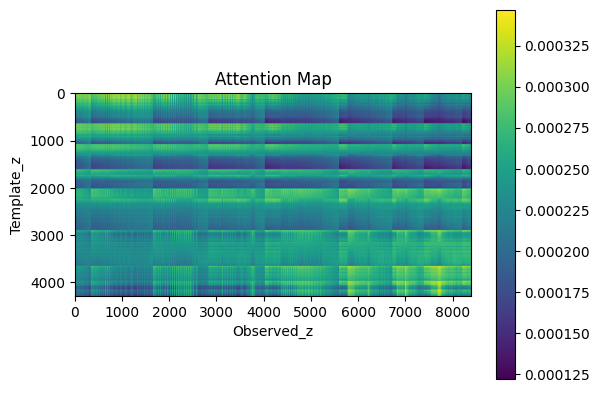

In [47]:
plot_attention(tr_attention_maps[1])

In [48]:
# plot_attention(va_attention_maps[24])

The attention map (a.k.a soft correspondence) attained here are of shape ($|V_t|$,$|V_k|$)

# 3. Domain Transformations

*Again, refering to Soodeh's paper...*

Using the **soft correspondence matrix** generated above (in section 2) for **soft attention**, we can perform domain transformation by passing **node features vector** along with the soft correspondences.

The new domain $\mathbf{x}^\prime_j$ can be presented with the formula below:

$$\mathbf{x}^\prime_j = \sum^{|V_k|}_{n=1} C_{jn}\mathbf{x}_n; j=\{1,...,|V_t|\}$$

where 
* $\mathbf{x}^\prime$ represents the **node features vector** in the other domain. 
* $\mathbf{x}_j^\prime$ is the $j$-th row of matrix $\mathbf{X}^\prime$ and 
* vector $\mathbf{x}_n$ presents $n$-th row of feature matrix $\mathbf{X}$.

Each **structurally normalised shape** $g^\prime_k$ is presented by node feature matrix $\mathbf{X}^\prime_k \in \mathbb{R}^{|V_t|\times 3}$. 


First, lets get the node feature matrices $\mathbf{X}_k$ for all the observed graphs $g_k$:

In [49]:
# to get the a new data object list w/o template mesh in it
tr_data_new = tr_data_processed[0:17]+tr_data_processed[18:]
print(len(tr_data_new))
tr_data_new

162


[Data(x=[2930, 3], edge_index=[2, 17505], pos=[2930, 3], face=[3, 5835]),
 Data(x=[8395, 3], edge_index=[2, 50382], pos=[8395, 3], face=[3, 16794]),
 Data(x=[8939, 3], edge_index=[2, 53604], pos=[8939, 3], face=[3, 17868]),
 Data(x=[4750, 3], edge_index=[2, 28479], pos=[4750, 3], face=[3, 9493]),
 Data(x=[5110, 3], edge_index=[2, 30621], pos=[5110, 3], face=[3, 10207]),
 Data(x=[9572, 3], edge_index=[2, 57369], pos=[9572, 3], face=[3, 19123]),
 Data(x=[3824, 3], edge_index=[2, 22887], pos=[3824, 3], face=[3, 7629]),
 Data(x=[3657, 3], edge_index=[2, 21900], pos=[3657, 3], face=[3, 7300]),
 Data(x=[6024, 3], edge_index=[2, 36114], pos=[6024, 3], face=[3, 12038]),
 Data(x=[5804, 3], edge_index=[2, 34812], pos=[5804, 3], face=[3, 11604]),
 Data(x=[5802, 3], edge_index=[2, 34800], pos=[5802, 3], face=[3, 11600]),
 Data(x=[3905, 3], edge_index=[2, 23388], pos=[3905, 3], face=[3, 7796]),
 Data(x=[3308, 3], edge_index=[2, 19797], pos=[3308, 3], face=[3, 6599]),
 Data(x=[2624, 3], edge_index=[

In [50]:
# # to get the a new data object list w/o template mesh in it
# va_data_new = va_data_processed[0:9]+va_data_processed[10:]
# print(len(va_data_new))
# va_data_new

We will then compare 2 types of calculations to get the structurally normalised shapes $g^\prime_k$:
1. More tedious, manual approach that performs calculation literally as stated in the formula above;
2. More intuitive approach where we can obtain node feature matrix of $\mathbf{X}^\prime_k \in \mathbb{R}^{|V_t|\times 3}$ \
    by multiplying $\mathbf{C}_k \in [0,1]^{|V_t|\times|V_k|}$ with $\mathbf{X}_k \in \mathbb{R}^{|V_k|\times 3}$

### 1st type of implementation for domain transformation
~~the above implementation may be **wrong**!~~ \
lets try to code literally as Soodeh's paper...

In [51]:
start_time = time.time()

trnorm_shapes = []

#x' is a single node feature vector (1, 3), what we want to have |V_t| of, for each x in the list
#x is also a single node feature vector (1,3) from 
#C_jn is the attention map, which is j x n, |V_t| x |V_k|

for i in range(len(tr_attention_maps)):
    current_map = tr_attention_maps[i] #(|V_t|, |V_k|)
    current_x = tr_data_new[i].x       #(|V_k|, 3)
    v_t, v_k = current_map.shape
    x_prime = torch.zeros((v_t, 3)) #create empty tensor of the output shape we want, (|V_t|, 3)
    for n in range(v_k):
        for j in range(v_t):
            values = current_map[j][n] * current_x[n]
            x_prime[j] += values #add the calculated values over j-th row in x_prime (one node), looped
#             print(current_map[j].shape, current_x[n].shape) #(|V_k|, 3)
    
    end_time = time.time()
    elapsed_time_min = (end_time - start_time)/60
    print(f"Elapsed time: {elapsed_time_min:.2f} minutes")
    break
    trnorm_shapes.append(x_prime)
     

Elapsed time: 2.83 minutes


### 2nd implementation of domain transformation

using `torch.matmul` to get the target sized input: $(|V_t|, 3)$

In [52]:
#to get structurally normalised shape g_k prime ('s node feature matrices)
#for each attention map, calculate the product of itself and the corresponded data.x
start_time = time.time()

trnorm_shapes = []

for i in range(len(tr_attention_maps)):
    shape = torch.matmul(tr_attention_maps[i], tr_data_new[i].x)
    trnorm_shapes.append(shape)
        
end_time = time.time()
elapsed_time_min = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time_min:.2f} minutes")

Elapsed time: 0.02 minutes


Lets compare! 

* 1st implementation was ran only for a single node feature matrix $\mathbf{X}_k$
    took ~3 minutes
* 2nd implementation ran for all the observed graphs node feature matrices 
    took 0.02 minutes
    
Now we compare the results:

In [53]:
#implementation 1 output:
x_prime

tensor([[ 74.0626, 118.3892,  11.0071],
        [ 72.7757, 116.3606,  10.8675],
        [ 73.0235, 116.7619,  10.8777],
        ...,
        [126.3284, 200.6036,  20.7652],
        [127.1213, 201.8564,  20.9067],
        [127.8049, 202.9377,  21.0287]])

In [54]:
#implementation 2 output:
trnorm_shapes[0]

tensor([[ 74.0626, 118.3892,  11.0071],
        [ 72.7757, 116.3606,  10.8675],
        [ 73.0235, 116.7619,  10.8777],
        ...,
        [126.3284, 200.6036,  20.7652],
        [127.1213, 201.8564,  20.9067],
        [127.8049, 202.9377,  21.0287]])

Turns out they have **exactly same** result! We will proceed with the 2nd implementation using the `trnorm_shapes` then.

In [56]:
print(len(trnorm_shapes))
# print(len(vanorm_shapes))

162


In [57]:
for shape in trnorm_shapes:
    print(shape.shape)

torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size([4285, 3])
torch.Size

In [58]:
tr=trnorm_shapes[0]
print(tr.shape)
tr

torch.Size([4285, 3])


tensor([[ 74.0626, 118.3892,  11.0071],
        [ 72.7757, 116.3606,  10.8675],
        [ 73.0235, 116.7619,  10.8777],
        ...,
        [126.3284, 200.6036,  20.7652],
        [127.1213, 201.8564,  20.9067],
        [127.8049, 202.9377,  21.0287]])

Although we will use the structurally normalised node feature matrix as the following BVAE's input, we can still **generate a mesh output** of the node feature matrices $\mathbf{X}^\prime_k$ and examine it, making sure the Attention Mechanism and Domain Transformation is executed well.

In [61]:
os.chdir("C:\\Users\jsl3a\Desktop\MSc Project Dataset\\nnUNet_raw\\Dataset001_amosCT")
temp_tr = tr_data_processed[17].face
mesh = trimesh.Trimesh(vertices=tr, faces=temp_tr.t())
mesh.export("dt_mesh_tr.stl")

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00v!\x00\x00\x1eQO?\xba\xc1\xfb\xbea\xd5\xa3\xbe\x12 \x94BF\xc7\xecB\xf6\x1c0A-\x8d\x91B\x9c\xb8\xe8B3\xe1-A\x07\x0c\x92B\x1c\x86\xe9B=\x0b.A\x00\x00?fQ?\xcf,\xff\xbe\x9c\x18\x93\xbe\x12 \x94BF\xc7\xecB\xf6\x1c0Aa\xef\x95B\xd4\x9b\xefBP\x0e2A$\xe6\x92B\xc5\xd2\xeaB\x9eP/A\x00\x00\xe6\xffN?G/\xfb\xbe3L\xa6\xbe-\x8d\x91B\x9c\xb8\xe8B3\xe1-A\x12 \x94BF\xc7\xecB\xf6\x1c0A$\xe6\x92B\xc5\xd2\xeaB\x9eP/A\x00\x00n\xf8Q?\xd3\xe1\xff\xbe\x91\x8a\x8e\xbea\xef\x95B\xd4\x9b\xefBP\x0e2A\x93\xa5\x97B>I\xf2B\xb7\xf23A\xe9\xa0\x94B\xe6\x86\xedB\xc5(1A\x00\x00P\xdbO?^F\xfc\xbe\xf9B\xa0\xbe$\xe6\x92B\xc5\xd2\xeaB\x9eP/Aa\xef\x95B\xd4\x9b\xefBP\x0e2A\xe9\xa0\x94B\xe6\x86\xedB\xc5(1A\x00\x00\

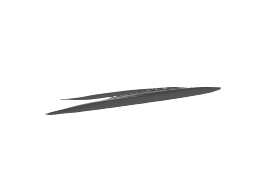

Unfortunately, the mesh generate looks nothing like the gallbladder mesh we are expecting. Lets look closer at the generated node feature matrix $\mathbf{X}^\prime_k$ here to see what is odd about it ---- compared to the original node feature matrix $\mathbf{X}_k$

In [62]:
temp_tr = tr_data_processed[17].x
print(temp_tr.shape)
print(torch.min(temp_tr[:,0]), torch.max(temp_tr[:,0]), torch.max(temp_tr[:,0]) - torch.min(temp_tr[:,0]))
print(torch.min(temp_tr[:,1]), torch.max(temp_tr[:,1]), torch.max(temp_tr[:,1]) - torch.min(temp_tr[:,1]))
print(torch.min(temp_tr[:,2]), torch.max(temp_tr[:,2]), torch.max(temp_tr[:,2]) - torch.min(temp_tr[:,2]))

torch.Size([4285, 3])
tensor(159.6426) tensor(219.2050) tensor(59.5624)
tensor(268.7768) tensor(329.0727) tensor(60.2959)
tensor(0.8836) tensor(41.5881) tensor(40.7045)


In [63]:
print(tr.shape)
print(torch.min(tr[:,0]), torch.max(tr[:,0]), torch.max(tr[:,0]) - torch.min(tr[:,0]))
print(torch.min(tr[:,1]), torch.max(tr[:,1]), torch.max(tr[:,1]) - torch.min(tr[:,1]))
print(torch.min(tr[:,2]), torch.max(tr[:,2]), torch.max(tr[:,2]) - torch.min(tr[:,2]))

torch.Size([4285, 3])
tensor(65.3157) tensor(133.1749) tensor(67.8592)
tensor(104.8550) tensor(213.5844) tensor(108.7293)
tensor(10.0725) tensor(21.1674) tensor(11.0949)


While both have the same shape, the original node matrix (cell[62]) has well balanced delta in the 3 dimensions (60, 60, 41) compared to the domain transformed node matrix's (cell[63]) delta (68, 109, 11)

## Discussion...
Upon further revision of the first 3 steps (VGAE, Attention Mechanism & Domain Transformation), I am still not able to pinpoint what leads to this issue we are facing. One suggestion could be to deploy another loss function, the Refinement Loss, which calculates:
1. Chamfer Loss for the distance of vertices between the graphs $g_k$ (original graph) and $g^\prime_k$ (domain transformed grpah)
2. and the Laplacian smoothness loss for smoother surface reconstruction

However, without access to the source code, it is *not clear how exactly it can be implemented*. There is no existing built-in library for the calculation of Chamfer Distance, and it is unclear whether if the Chamfer Distance should be integrated with the VGAE optimisation (which will exponentially increase the computational headroom) or perform as a standalone optimisation after the VGAE training.

Chamfer_distance codes found on GitHub includes [this](https://github.com/otaheri/chamfer_distance) and [thiss](https://github.com/ThibaultGROUEIX/ChamferDistancePytorch/blob/master/chamfer3D/dist_chamfer_3D.py).

## For now,

The project will continue to the next phase of shape generation despite not having the optimum input data for the generative model...


Finally, a generation network, designed in $\beta$**-VAE framework**, learns a PDF from a set of $\{g^\prime_k\}^K_{k=1}$ graphs, allowing the **generation** of cohorts of artificial shapes

# 4. $\beta$-VAE & Shape Generation

The final model of the framework involves a $\beta$**-VAE** to perform **shape generation**, using the *structurally normalised shapes* produced from section 3 (presented by a list of matrices). \
For the ease of implementation, we will define a simple VAE model that holds a hyperparameter $\beta$ that can be input when initializing the model

## 4.1 Fitting the uniform shapes into `DataLoader`

We will fit the list of tensors, the *structurally normalised shapes* we have into said `DataLoader`.

To do that, we will have to make a simple *custom* `dataset`:

In [64]:
import torch
from torch.utils.data import Dataset, DataLoader

class St_Norm_Dataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        sample = self.data_list[idx]
        return sample

# Create a CustomTensorDataset instance
trdataset = St_Norm_Dataset(trnorm_shapes)
# vadataset = St_Norm_Dataset(vanorm_shapes)

# Create a DataLoader
batch_size = 1
trnorm_loader = DataLoader(trdataset, batch_size=batch_size, shuffle=True)
# vanorm_loader = DataLoader(vadataset, batch_size=batch_size, shuffle=True)

# Iterate over the DataLoader
for batch in trnorm_loader:
    print(batch.shape)
    print(batch[0].shape)
    break
    
# for batch in vanorm_loader:
#     print(batch.shape)
#     print(batch[0].shape)
#     break


torch.Size([1, 4285, 3])
torch.Size([4285, 3])


## 4.2 Defining $\beta$-VAE

Following Soodeh's implementation, the following $\beta$-VAE has the dimension of `(512,256,768,128,64)` for the encoder, with its decoder being a **mirrored** version of the encoder. All internal layers use `batchnorm` and `LeakyReLU` as activation layers 

Again, the loss function is a combination of reconstruction loss and KL divergence (both built in to the model)

In [68]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),  
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),  
            nn.Linear(256, 768),
            nn.BatchNorm1d(768),
            nn.LeakyReLU(), 
            nn.Linear(768, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),  
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),    
        )
        
        self.lin_mu = nn.Linear(64, 64)
        self.lin_logvar = nn.Linear(64, 64)
        
    def forward(self, x):
        x = self.layers(x)
        mean = self.lin_mu(x)
        logvar = self.lin_logvar(x)
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),  
            nn.Linear(128, 768),
            nn.BatchNorm1d(768),
            nn.LeakyReLU(), 
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),  
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),  
            nn.Linear(512, 3),
            nn.ReLU(),  
        )
        
    def forward(self, x):
        return self.layers(x)

class BetaVAE(nn.Module):
    def __init__(self, beta=1.0):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.beta = beta
        
    def forward(self, x):
        mean, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        
        #reparameterization
        z = mean + std * epsilon
        
        recon_x = self.decoder(z)
        return recon_x, mean, logvar

    def loss_function(self, recon_x, x, mean, logvar):
        mean, logvar = self.encoder(x)
        reconstruction_loss = nn.MSELoss(reduction='mean')(recon_x, x)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        return reconstruction_loss + self.beta * kl_divergence


In [69]:
import torch.optim as optim

# Hyperparameters
beta = 2e-6 #4, 1, 1e-2, Soodeh's: 2e-6
learning_rate = 1e-3
num_epochs = 500

# Create the model
bvae = BetaVAE(beta)

# Define optimizer
optimizer_b = optim.Adam(bvae.parameters(), lr=learning_rate)

bvae = bvae.to(device)
bvae

BetaVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=256, out_features=768, bias=True)
      (7): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Linear(in_features=768, out_features=128, bias=True)
      (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.01)
      (12): Linear(in_features=128, out_features=64, bias=True)
      (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [70]:
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    bvae.train()
    total_loss = 0.0
    for batch in trnorm_loader:
        optimizer_b.zero_grad()
        inputs = batch[0].to(device)
        recon_batch, mean, logvar = bvae(inputs)
        loss = bvae.loss_function(recon_batch, inputs, mean, logvar)
        loss.backward()
        optimizer_b.step()
        total_loss += loss.item()
        
    average_loss = total_loss / len(trnorm_loader.dataset)
    if (epoch%50==0):
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
    

print(average_loss)
end_time = time.time()
elapsed_time_min = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time_min:.2f} minutes")

Epoch [1/500], Loss: 26183.4234
Epoch [51/500], Loss: 4571.4485
Epoch [101/500], Loss: 3165.6603
Epoch [151/500], Loss: 2380.8254
Epoch [201/500], Loss: 1990.2561
Epoch [251/500], Loss: 1771.8613
Epoch [301/500], Loss: 1338.1161
Epoch [351/500], Loss: 1348.6221
Epoch [401/500], Loss: 678.2062
Epoch [451/500], Loss: 593.1708
478.1773379996971
Elapsed time: 19.31 minutes


### save the bvae model state

In [71]:
os.chdir("C:\\Users\jsl3a\Desktop\MSc Project Dataset\\nnUNet_raw\\Dataset001_amosCT")

# Define the file path where you want to save the model
file_path = "model/bbvae_b2en6_500_final.pth" #beta=2e-6
# file_path = "model/bbvae_b2en6_500.pth" #beta=2e-6
# file_path = "model/bbvae_b001_500.pth" #beta=1e-2
# file_path = "model/bvae_b001_800.pth" #beta=1e-2


# Save the entire model state (including model parameters and other information)

checkpoint_b = {
    'model_state_dict': bvae.state_dict(),
    'optimizer_state_dict': optimizer_b.state_dict(),
}

torch.save(checkpoint_b, file_path)


### load the model state

In [72]:
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Define the file path where you want to save the model
# # file_path = "model/bvae_b001_500.pth" #beta=1e-2
# # file_path = "model/bvae_b001_800.pth" #beta=1e-2
# file_path = "model/bvae_b4_500.pth" #beta=4

# # Hyperparameters
# latent_dim = 64
# beta = 1e-2 #2e-6, 4, 1, 1e-2
# learning_rate = 1e-3

# # Create the model
# bvae = BetaVAE(latent_dim, beta)
# bvae = bvae.to(device)

# # Define optimizer
# optimizer_b = optim.Adam(bvae.parameters(), lr=learning_rate)

# #loading checkpoint to resume training
# checkpoint = torch.load(file_path)
# bvae.load_state_dict(checkpoint['model_state_dict'])
# optimizer_b.load_state_dict(checkpoint['optimizer_state_dict'])


## 4.3 Now to produce the new output 

~~do we use training data or validation?~~\
remember to set the model to non training mode (eval?)

In [73]:
def bvae_output(bvae, dataloader):
    start_time = time.time()

    output = []
    bvae.eval()
    for i, data in enumerate(dataloader, 0):
        with torch.no_grad():
            data = data.to(device)
            recon, _, _ = bvae(data)
            recon = recon.detach().cpu()
        output.append(recon)
       
    elapsed_time_min = (time.time() - start_time)/60
    print(f"Elapsed time: {elapsed_time_min:.2f} minutes")
    return output

In [74]:
tr_recon = bvae_output(bvae, trnorm_shapes)
tr_recon

Elapsed time: 0.01 minutes


[tensor([[ 69.3200, 120.1962,  14.1101],
         [ 68.1838, 118.1475,  13.9109],
         [ 68.4008, 118.7393,  14.0419],
         ...,
         [ 71.9901, 125.5559,  14.5960],
         [ 71.6292, 124.9201,  14.5575],
         [ 72.8470, 126.8865,  14.6889]]),
 tensor([[100.4932, 167.2144,  14.4000],
         [102.0125, 169.1004,  14.5393],
         [101.6839, 168.2167,  14.6158],
         ...,
         [ 88.8955, 148.4047,  15.0692],
         [ 89.8760, 149.4697,  15.2349],
         [ 88.7814, 148.3378,  15.0727]]),
 tensor([[145.6048, 232.1616,  24.7003],
         [144.9441, 230.2940,  24.7235],
         [145.7438, 231.6662,  24.8274],
         ...,
         [152.3529, 246.1178,  25.7698],
         [148.0674, 226.8968,  24.8699],
         [151.9689, 245.3692,  25.5341]]),
 tensor([[127.2547, 199.5198,  22.0267],
         [129.8616, 203.2081,  21.9002],
         [128.9666, 201.9046,  21.8490],
         ...,
         [117.9810, 190.3545,  20.0053],
         [117.3739, 189.7548,  19.94

In [75]:
tt = tr_recon[0]

print("-"*50)
print(torch.min(tt[:,0]), torch.max(tt[:,0]), torch.max(tt[:,0]) - torch.min(tt[:,0]))
print(torch.min(tt[:,1]), torch.max(tt[:,1]), torch.max(tt[:,1]) - torch.min(tt[:,1]))
print(torch.min(tt[:,2]), torch.max(tt[:,2]), torch.max(tt[:,2]) - torch.min(tt[:,2]))
print("-"*50)

--------------------------------------------------
tensor(65.3158) tensor(81.7599) tensor(16.4442)
tensor(113.0310) tensor(139.0809) tensor(26.0499)
tensor(13.6436) tensor(15.2370) tensor(1.5934)
--------------------------------------------------


Again, looking at the delta of the tensor here, the mesh will not look decent

In [76]:
# va_recon = bvae_output(bvae, vanorm_shapes)
# va_recon

## 4.4 Convert the output to actual meshes:

To produce the meshes, we will take the tensors from `tr_recon` and ~~`va_recon`~~ as `x` and their respective template's `edge_index` to combine into `Data` objects as seen in **`1.1.4`**.

We can then use the `trimesh` library to produce the final mesh. 

In [77]:
print(tr_recon[0].shape)
print(tr_recon[45].shape)
# print(va_recon[3].shape)
# print(va_recon[45].shape)

torch.Size([4285, 3])
torch.Size([4285, 3])


Looking at **training** data template_z:

In [78]:
print(template_trz.shape)
print(tr_data_processed[17])

torch.Size([4285, 128])
Data(x=[4285, 3], edge_index=[2, 25698], pos=[4285, 3], face=[3, 8566])


Looking at **validation** data template_z:

In [79]:
# print(template_vaz.shape)
# print(va_data_processed[10])

when viewing the reconstructed meshes in Paraview, it is flat (instead of 3D). This can be due to a few reasons & we will be going through the possibilites one by one:
1. invalid vertex order - triangles should have consistent winding order (counter-cw or cw)
2. missing faces/ faces incorrectly defined
3. degenerate faces - triangles with nearly collinear vertices can cause rendering artifacts. make sure each vertices are well-defined
4. **scaling issues** - extreme differences in scale between the dimensions of mesh can cause visual issues. make sure the mesh is in a reasonable scale & units are consistent
5. mesh quality - poorly conditioned meshes with very acute angles, long skinny triangles, or other irregularities can result in rendering problems.


~~***[DEALT WITH, 23/08/2023]*** I am actually more suspicious that this is a scaling issues. Upon checking (shown above), there is a **10X** difference in the vertices' range between the template mesh (`checkmesh`) and reconstructed mesh (`final_mesh_tr[0]`)!~~

~~the **data** we fed to the BVAE, from `trnorm_loader`, has **too little consistency**. this *can* be the reason of why the output from BVAE has such massive scale compared to what we had. ~~

~~To limit the range in `trnorm_loader`, we might want to do the **clipping** in notebook 1 where we preprocess the data - essentially *clip those outliers segmentations* where prostate includes higher-up organs, making them too big...~~

~~We also added lambda (`lbd`), 0.1 to the **`2.2`** correspondence calculation.~~

### 4.4.1 Converting reconstructed output into Trimesh object using `trimesh`

~~there will be problem of `face` & `faces` having different shapes.~~
* ~~e.g. face has shape `(3,5820)` instead of `(5820,3)` (and we can't just t it)~~


In [81]:
import trimesh

def generateTrimesh(recon_list, template_faces, folder_path):
    """read reconstructed vertices from list one by one, 
    combine with template_faces, make a trimesh one by one,
    save to folder_path & return all the trimesh in a list

    Args:
        recon_list: list of the PyG data objects
        template_faces: template for reconstructing mesh, should contain faces
        folder_path: The path to save the trimesh files.

    Returns:
        a list with all the trimesh objects
    """
    list = []
    
    for idx, vert in enumerate(recon_list):
        vert_cpu = vert.detach().cpu()
        template_faces_cpu = template_faces.detach().cpu()
        mesh = trimesh.Trimesh(vertices=vert_cpu, faces=template_faces_cpu.t())
        list.append(mesh)
        mesh.export(folder_path+"/recon_mesh"+str(idx)+".stl")
    
    return list

In [82]:
temp_tr = tr_data_processed[17]
# temp_va = va_data_processed[9]

# folder_tr = 'version1/gb_recon_tr_b001'
# folder_va = 'version1/gb_recon_va_b001'
folder_tr = 'version1/test'
# folder_va = 'version1/test0'

final_mesh_tr = generateTrimesh(tr_recon, temp_tr.face, folder_tr)
# final_mesh_va = generateTrimesh(va_recon, temp_va.face, folder_va)

In [83]:
temp_tr

Data(x=[4285, 3], edge_index=[2, 25698], pos=[4285, 3], face=[3, 8566])

In [84]:
final_mesh_tr

[<trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4273, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(4285, 3), faces.shape=(8566, 3))>,
 <trimesh.Trimesh(vertices.shape=(

To show the final output mesh:

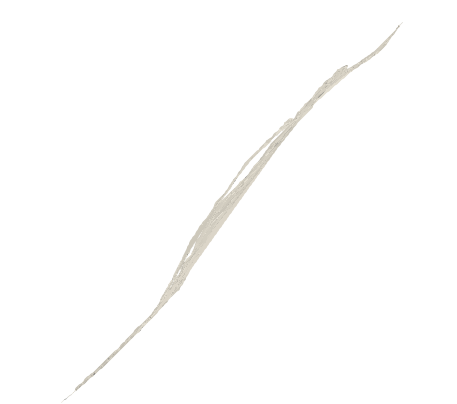

now that the BVAE is reimplemented & the output is still faulty, we should look into the **attention mechanism** & **domain transformation**. (VGAE is checked and produces good output so the z produced should be fine)

are those output correct? seems like BVAE is producing similar output to the domain transformation's `trnorm_shapes`. 

~~When we try to create trimesh using the original edge index + domain transformation output (pre-bvae), we get the needle shaped mesh as well!~~

### what else can we modify for the attention mechanism & domain transformation?